In [1]:
import SimpleITK as sitk

import matplotlib.pyplot as plt
from pathlib import Path

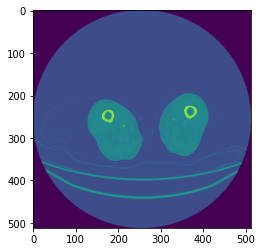

In [2]:
mr_image = sitk.ReadImage(Path("data/anonymise_patient1.mhd"))
npa = sitk.GetArrayViewFromImage(mr_image)

# Display the image slice from the middle of the stack, z axis
z = int(mr_image.GetDepth()/2)
npa_zslice = sitk.GetArrayViewFromImage(mr_image)[z,:,:]

plt.imshow(npa_zslice)